In [2]:
# updated
###############     OpenSG         ############################
########### Timo Model (dolfinx) ###################
from dolfinx.io import gmshio
from dolfinx.fem.petsc import LinearProblem, assemble_matrix
from dolfinx.mesh import locate_entities_boundary, exterior_facet_indices, create_submesh
from mpi4py import MPI
import numpy as np
import meshio
import dolfinx
from dolfinx.fem import form, petsc, Function, functionspace, locate_dofs_topological, apply_lifting, set_bc
from ufl import Jacobian, as_vector, dot, cross,sqrt, conditional, replace, as_matrix,FacetNormal
from ufl import lt,SpatialCoordinate, as_tensor,  Measure
from ufl import TrialFunction, TestFunction, inner, lhs, rhs, dx, dot,eq
import petsc4py.PETSc
from contextlib import ExitStack
from dolfinx.io import gmshio
from mpi4py import MPI
from pathlib import Path
from typing import Dict
import ufl
import basix
from scipy.sparse import csr_matrix
import numpy as np
import yaml
from yaml import CLoader as cLd

## Define input parameters

meshYaml = 'tapered_solid.yaml'  ## the name of the yaml file containing the whole blade mesh
secInd = np.linspace(2,3,1) ## the index of the spanwise section you want
mshFile = 'SG_solid.msh'
oriFile = 'solid.orientation'

## Read the mesh yaml file

inFile = open(meshYaml,'r')
meshData = yaml.load(inFile,Loader=cLd)
inFile.close()
## Extract the mesh for the section
nodes = meshData['nodes']
numNds = len(nodes)
elements = meshData['elements']
numEls = len(elements)
elLayID = np.ones(numEls,dtype=int)
elLayID=[]
mat_name=[]
layCt=-1
for es in meshData['sets']['element']:
    mat_name.append(es['name'])
    layCt += 1
    for eli in es['labels']:
        elLayID.append(layCt)

    
## Write .msh file
outFile = open(mshFile,'w')

outFile.write('$MeshFormat\n2.2 0 8\n$EndMeshFormat\n$Nodes\n')
outFile.write(str(len(nodes)) + '\n')

for i, nd in enumerate(nodes):
        ndd=nd[0].split()
        ln = [str(i+1),str(ndd[2]),str(ndd[0]),str(ndd[1])]
        outFile.write(' '.join(ln) + '\n')

outFile.write('$EndNodes\n$Elements\n')

newNumEls = len(elements)
outFile.write(str(newNumEls) + '\n')

for i, el in enumerate(elements):
        ln = [str(i+1)]
        ln.append('5')
        ln.append('2')
        ln.append('2')
        ln.append(str(elLayID[i]))    
        ell=el[0].split()
        for n in ell:
            ln.append(n)
        outFile.write(' '.join(ln) + '\n')
outFile.write('$EndElements\n')

outFile.close()
mesh, subdomains, boundaries = gmshio.read_from_msh("SG_solid.msh", MPI.COMM_WORLD,0, gdim=3)
pp=mesh.geometry.x
x_min,x_max=min(pp[:,0]), max(pp[:,0])
fdim=2
def left(x):
    return np.isclose(x[0], x_min)
def right(x):
    return np.isclose(x[0], x_max)

tdim=mesh.topology.dim
fdim = tdim - 1
facets_left = dolfinx.mesh.locate_entities_boundary(mesh, dim=fdim,
                                       marker=left)
facets_right = dolfinx.mesh.locate_entities_boundary(mesh, dim=fdim,
                                       marker=right)

mesh_r, entity_mapr, vertex_mapr, geom_mapr = create_submesh(mesh, fdim, facets_right)
mesh_l, entity_mapl, vertex_mapl, geom_mapl = create_submesh(mesh, fdim, facets_left)

Info    : Reading 'SG_solid.msh'...
Info    : 19960 nodes
Info    : 15448 elements
Info    : Done reading 'SG_solid.msh'


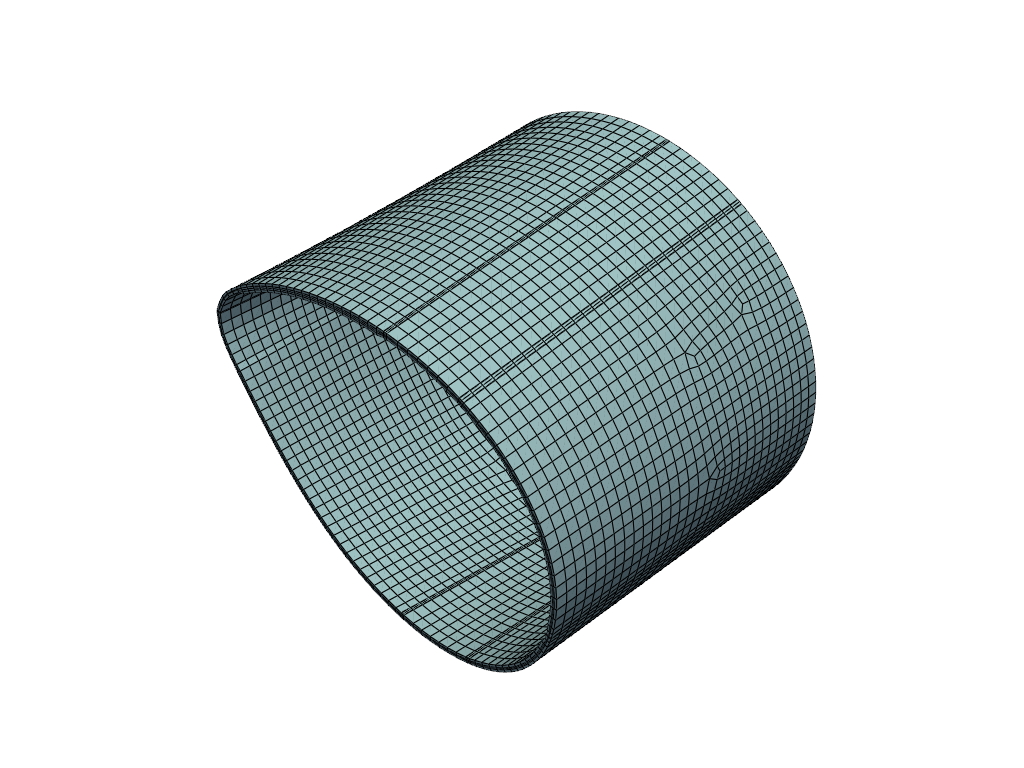

In [7]:
import pyvista
pyvista.start_xvfb()
u_topology, u_cell_types, u_geometry=dolfinx.plot.vtk_mesh(mesh,fdim+1)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)

u_plotter.show()

In [2]:
# Material_ID
o_cell_idx =  mesh.topology.original_cell_index
lnn=[]
for k in o_cell_idx:
    lnn.append(elLayID[k])
lnn=np.array(lnn,dtype=np.int32)    

cell_map = mesh.topology.index_map(mesh.topology.dim)
num_cells_on_process = cell_map.size_local + cell_map.num_ghosts
cells = np.arange(num_cells_on_process, dtype=np.int32)
subdomains = dolfinx.mesh.meshtags(mesh, mesh.topology.dim, cells, lnn)

# Material parameters:

# carbon_uni
E1,E2,E3=157599000000.0, 9100000000.0,9100000000.0
G12,G13,G23= 4131000000.0, 4131000000.0,2689000000.0
v12,v13,v23= 0.3133, 0.3133,0.47066
material_parameters=[(E1,E2,E3,G12,G13,G23,v12,v13,v23)]
# glass_triax
E1,E2,E3=28211400000.0, 16238800000.0,15835500000.0
G12,G13,G23= 8248220000.0, 3491240000.0,3491240000.0
v12,v13,v23= 0.497511, 0.18091,0.27481
material_parameters.append([E1,E2,E3,G12,G13,G23,v12,v13,v23])


In [3]:
# Local Orientation (DG0 function)

VV = dolfinx.fem.functionspace(mesh, basix.ufl.element(
    "DG", mesh.topology.cell_name(), 0, shape=(3, )))

EE1,EE2,N=Function(VV),Function(VV),Function(VV) 

orien=[]
for i, eo in enumerate(meshData['elementOrientations']):
        o=[]
        for k in range(6):
            o.append(eo[k])
        orien.append(o)
       
# Store orientation for each element
for k,ii in enumerate(o_cell_idx):
    a1=np.array(orien[ii][0:3])   
    b1=np.array(orien[ii][3:6])
    E3=np.cross(a1,b1)
    E3/=np.linalg.norm(E3)
    E1=a1/np.linalg.norm(a1)
    E2=np.cross(E3,E1)
    
    # Storing data to DG0 functions 
    EE1.vector[3*k],EE1.vector[3*k+1],EE1.vector[3*k+2]=E1   # e1
    EE2.vector[3*k],EE2.vector[3*k+1],EE2.vector[3*k+2]=E2 #  e2 
    N.vector[3*k], N.vector[3*k+1],N.vector[3*k+2]=E3        # e3 normal same as +x3 direction based on ABD.

In [4]:
# Direction cosine matrix
b=as_tensor([(EE1[0],EE1[1],EE1[2]),(EE2[0],EE2[1],EE2[2]),(N[0],N[1],N[2])])
b1=[[b[i,j]*b[i,j] for j in range(3)] for i in range(3)]
b2=2*[[ b[i,1]*b[i,2], b[i,0]*b[i,2], b[i,0]*b[i,1]] for i in range(3)]
j=0
b31=[b[1,j]*b[2,j], b[1,j+1]*b[2,j+1], b[1,j+2]*b[2,j+2]]
b32=[b[0,j]*b[2,j], b[0,j+1]*b[2,j+1], b[0,j+2]*b[2,j+2]]
b33=[b[0,j]*b[1,j], b[0,j+1]*b[1,j+1], b[0,j+2]*b[1,j+2]]
b3=[b31,b32,b33]
b41= [b[1,2]*b[2,1]+b[1,1]*b[2,2], b[1,2]*b[2,0]+b[1,0]*b[2,2], b[1,0]*b[2,1]+b[1,1]*b[2,0]]
b42= [b[0,2]*b[2,1]+b[0,1]*b[2,2], b[0,2]*b[2,0]+b[0,0]*b[2,2], b[2,0]*b[0,1]+b[0,0]*b[2,1]]
b43= [b[0,2]*b[1,1]+b[0,1]*b[1,2], b[0,2]*b[1,0]+b[0,0]*b[1,2], b[1,0]*b[0,1]+b[1,1]*b[0,0]]
b4=[b41,b42,b43]
R_sig=as_tensor([(b1[0][0],b1[0][1], b1[0][2],b2[0][0],b2[0][1], b2[0][2]),
             (b1[1][0],b1[1][1], b1[1][2],b2[1][0],b2[1][1], b2[1][2]),
             (b1[2][0],b1[2][1], b1[2][2],b2[2][0],b2[2][1], b2[2][2]),
             (b3[0][0],b3[0][1], b3[0][2],b4[0][0],b4[0][1], b4[0][2]),
             (b3[1][0],b3[1][1], b3[1][2],b4[1][0],b4[1][1], b4[1][2]),
             (b3[2][0],b3[2][1], b3[2][2],b4[2][0],b4[2][1], b4[2][2]),
            ])

In [6]:

nphases = len(material_parameters)
x=SpatialCoordinate(mesh)

def gamma_h(dx,v):
    E1=as_vector([0,v[1].dx(1),v[2].dx(2),v[1].dx(2)+v[2].dx(1),v[0].dx(2),v[0].dx(1)])
    return E1
def gamma_l(dx,v):
    E1=as_vector([v[0],0,0,0, v[2],v[1]])
    return E1
    
def C(i):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[0]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12 
    CC=as_tensor(np.linalg.inv(S))

    return dot(dot(R_sig,CC),R_sig.T)


x = ufl.SpatialCoordinate(mesh)

def Eps2(x):
 a,b=1,2
 return as_tensor([(1,0,x[b],-x[a]),
                (0,0,0,0),
                (0,0,0,0),
                (0,0,0,0),
               (0,x[a],0,0),
               (0,-x[b],0,0)])

V= dolfinx.fem.functionspace(mesh, basix.ufl.element(
    "CG", mesh.topology.cell_name(), 1, shape=(3, )))
dv = TrialFunction(V)
v_ = TestFunction(V)
V_l= dolfinx.fem.functionspace(mesh_l, basix.ufl.element(
    "CG", mesh_l.topology.cell_name(), 1, shape=(3, )))
dvl = TrialFunction(V_l)
v_l= TestFunction(V_l)

V_r= dolfinx.fem.functionspace(mesh_r, basix.ufl.element(
    "CG", mesh_r.topology.cell_name(), 1, shape=(3, )))
dvr = TrialFunction(V_r)
v_r= TestFunction(V_r)

x, dx= SpatialCoordinate(mesh), Measure('dx')(domain=mesh, subdomain_data=subdomains)


In [7]:
# Cell-Facet connectivity 
# Subdomain mapping to boundary mesh

mesh.topology.create_connectivity(3,2)
cell_of_face_mesh=mesh.topology.connectivity(3,2)
# Cell to Face connectivity
nelem=int(len(cell_of_face_mesh.array)/6)
conn3=[]
for i in range(nelem):
    c=[]
    for k in range(6):
        c.append((cell_of_face_mesh.array[6*i+k]))
    conn3.append(c)

#Left face
sub_L=[]
boundary_facets = dolfinx.mesh.locate_entities(mesh, fdim, left)
boundary_facets_left= dolfinx.mesh.locate_entities(mesh_l, fdim, left)
for i,xx in enumerate(boundary_facets_left):
    
        for ii,k in enumerate(conn3):
            if entity_mapl[i] in k:
                sub_L.append(subdomains.values[ii])

sub_L= np.array(sub_L,dtype=np.int32)
cell_map_l = mesh_l.topology.index_map(mesh_l.topology.dim)
num_cells_on_process_l = cell_map_l.size_local + cell_map_l.num_ghosts
cells_l = np.arange(num_cells_on_process_l, dtype=np.int32)
subdomains_l = dolfinx.mesh.meshtags(mesh_l, mesh_l.topology.dim, cells_l, sub_L)

#Right face
sub_R=[]
boundary_facets = dolfinx.mesh.locate_entities(mesh, fdim, right)
boundary_facets_right= dolfinx.mesh.locate_entities(mesh_r, fdim, right)
for i,xx in enumerate(boundary_facets_right):
        for ii,k in enumerate(conn3):
            if entity_mapr[i] in k:
                sub_R.append(subdomains.values[ii])
                
sub_R= np.array(sub_R,dtype=np.int32)

cell_map_r = mesh_r.topology.index_map(mesh_r.topology.dim)
num_cells_on_process_r = cell_map_r.size_local + cell_map_r.num_ghosts
cells_r = np.arange(num_cells_on_process_r, dtype=np.int32)
subdomains_r = dolfinx.mesh.meshtags(mesh_r, mesh_r.topology.dim, cells_r, sub_R)

x_l, dx_l= SpatialCoordinate(mesh_l), Measure('dx')(domain=mesh_l, subdomain_data=subdomains_l)
x_r, dx_r= SpatialCoordinate(mesh_r), Measure('dx')(domain=mesh_r, subdomain_data=subdomains_r)

In [8]:
mesh.topology.create_connectivity(2, 3)
            
boundary_facets= exterior_facet_indices(mesh.topology)
boundary_dofs = locate_dofs_topological(V, fdim, np.concatenate((entity_mapr,entity_mapl), axis=0))

v2a=Function(V)

Eps=Eps2(x)[:,0] 
from scipy.sparse import csr_matrix
F2 = sum([dot(dot(C(i),gamma_h(dx,dv)), gamma_h(dx,v_))*dx(i) for i in range(nphases)])# bc 

bc = dolfinx.fem.dirichletbc(v2a, boundary_dofs)
# Obtain coefficient matrix without BC applied: BB
a= form(lhs(F2))
B=assemble_matrix(a)
B.assemble()
ai, aj, av=B.getValuesCSR()
BB=csr_matrix((av, aj, ai))
BB=BB.toarray()  

In [ ]:

#-------------------------------------------------- 
# Obtain coefficient matrix with BC applied: AA
A=assemble_matrix(a,[bc])
A.assemble()
ai, aj, av=A.getValuesCSR()
AA=csr_matrix((av, aj, ai))
AA=AA.toarray()
avg=np.trace(AA)/len(AA)     
# 
for i,x in enumerate(av):
    if x==1:
        av[i]=avg      
AA_csr=scipy.sparse.csr_matrix((av, aj, ai))
AAA=AA_csr.toarray() 
AA=scipy.sparse.csr_matrix(AAA) 


In [ ]:
# Left Nullspace
def nullspace(V_l):
    index_map = V.dofmap.index_map
    nullspace_basis = [dolfinx.la.create_petsc_vector(index_map, V_l.dofmap.index_map_bs) for i in range(4)]
    
    with ExitStack() as stack:
        vec_local = [stack.enter_context(xx.localForm()) for xx in nullspace_basis]
        basis = [np.asarray(xx) for xx in vec_local]
    
    # Dof indices for each subspace (x, y and z dofs)
    dofs = [V_l.sub(i).dofmap.list for i in range(3)]
    
    # Build translational null space basis
    for i in range(3):
        basis[i][dofs[i]] = 1.0
    
    # Create vector space basis and orthogonalize
    dolfinx.la.orthonormalize(nullspace_basis)
    
    return petsc4py.PETSc.NullSpace().create(nullspace_basis, comm=MPI.COMM_WORLD)
    
nullspace_l,nullspace_r=nullspace(V_l), nullspace(V_r)   

def A(x,dx,dv,v_,null):
    F2 = sum([dot(dot(C(i),gamma_h(dx,dv)), gamma_h(dx,v_))*dx(i) for i in range(nphases)])   
    a2=form(F2)
    A_l=assemble_matrix(a2)
    A_l.assemble()
    A_l.setNullSpace(null)
    return A_l

A_l,A_r=A(x_l,dx_l,dvl,v_l,nullspace_l), A(x_r,dx_r,dvr,v_r,nullspace_r)
V0_l=np.zeros((3*V_l.dofmap.index_map.local_range[1],4))
V0_r=np.zeros((3*V_r.dofmap.index_map.local_range[1],4))                    


# In[7]:


def boun_V0(e,x,dx,dv,v_,V,A,p): 

    xxx= 3*V.dofmap.index_map.local_range[1]
    Eps=gamma_e(e,x)[:,p]
 #   F2 = sum([dot(dot(ABD_matrix(i),Eps), gamma_h(e,x,v_))*dx(i) for i in range(nphases)])
    F2= sum([dot(dot(ABD_matrix(i),Eps+gamma_h(e,x,dv)), gamma_h(e,x,v_))*dx(i) for i in range(nphases)])
    r_he=form(rhs(F2))
    F_l = petsc.assemble_vector(r_he)
    F_l.ghostUpdate(addv=petsc4py.PETSc.InsertMode.ADD, mode=petsc4py.PETSc.ScatterMode.REVERSE)
    w_l=Function(V)
    
    nullspace_l.remove(F_l) # nullspace_l
    # ksp solve
    ksp = petsc4py.PETSc.KSP()
    ksp.create(comm=MPI.COMM_WORLD)
    ksp.setOperators(A) # A
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("mumps")
    ksp.getPC().setFactorSetUpSolverType()
    ksp.getPC().getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)  # detect null pivots
    ksp.getPC().getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)  # do not compute null space again
    ksp.setFromOptions()
    ksp.solve(F_l, w_l.vector)
    w_l.vector.ghostUpdate(
        addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)
    ksp.destroy()
    return w_l,F_l
    
mesh_l.topology.create_connectivity(1, 1)
mesh_r.topology.create_connectivity(1, 1)
global_facets_l,global_facets_r  = locate_entities(mesh, fdim, left), locate_entities(mesh, fdim, right)
local_facets_l,local_facets_r = locate_entities(mesh_l, fdim, left), locate_entities(mesh_r, fdim, right)

def dof_mapping(v2a,w_l,V_l,boundary_facets,boundary_facets_left):
        dof_S2L=[]
        for i,xx in enumerate(boundary_facets):
            dofs = locate_dofs_topological(V,1, np.array([xx]))
            dofs_left= locate_dofs_topological(V_l,1, np.array([boundary_facets_left[i]]))
    
            for k in range(deg+1):
                if dofs[k] not in dof_S2L:
                    dof_S2L.append(dofs[k])
                    l=3*dofs_left[k],3*dofs_left[k]+1, 3*dofs_left[k]+2
                    m=3*dofs[k],3*dofs[k]+1,3*dofs[k]+2
                    v2a.vector[m]=w_l.vector[l] # store boundary solution of fluctuating functions
        return v2a


# In[8]:


# Assembly
xxx=3*V.dofmap.index_map.local_range[1]
V0 = np.zeros((xxx,4))
Dhe=np.zeros((xxx,4))
D_ee=np.zeros((4,4))
#
Dle=np.zeros((xxx,4))
Dhd=np.zeros((xxx,4))
Dld=np.zeros((xxx,4))
D_ed=np.zeros((4,4))
D_dd=np.zeros((4,4))
V1s=np.zeros((xxx,4))

for p in range(4): # 4 load cases meaning 
    v2a=Function(V)
    # Left Boundary 
    w_l=boun_V0(e_l,x_l,dx_l,dvl,v_l,V_l,A_l,p)[0]
    V0_l[:,p]=w_l.vector[:]
    v2a=dof_mapping(v2a,w_l,V_l,global_facets_l,local_facets_l)

    # Right Boundary
    w_r=boun_V0(e_r,x_r,dx_r,dvr,v_r,V_r,A_r,p)[0]
    V0_r[:,p]=w_r.vector[:]
    v2a=dof_mapping(v2a,w_r,V_r,global_facets_r,local_facets_r)
    
    # Compute Quad mesh
    w=Function(V)
    Eps=gamma_e(e,x)[:,p] 
    F2 = sum([dot(dot(ABD_matrix(i),Eps), gamma_h(e,x,v_))*dx(i) for i in range(nphases)]) 
    # bc 
    bc = dolfinx.fem.dirichletbc(v2a, boundary_dofs)
    b= form(-F2)
#------------------------------------------------------------------------------------- 
    F = petsc.assemble_vector(b)
    apply_lifting(F, [ahh], [[bc]]) # apply bc to rhs vector (Dhe) based on known fluc solutions
    set_bc(F, [bc])
    FF=F[:]
    for i in boundary_dofs:
        for k in range(3):
            FF[3*i+k]=avg*F[3*i+k] # normalize small terms

    V0[:,p]= scipy.sparse.linalg.spsolve(AA, FF, permc_spec=None, use_umfpack=True) # obtain sol: E* V1s = b*
    Dhe[:,p]=  np.matmul(BB,V0[:,p]) # obtain b : E * V1s
    print('Computed EB:',25*(p+1),'%') 
D1=np.matmul(V0.T,-Dhe) 

for s in range(4):
    for k in range(4): 
        f=sum([dot(dot(gamma_e(e,x).T,ABD_matrix(i)),gamma_e(e,x))[s,k]*dx(i) for i in range(nphases)])
        D_ee[s,k]=dolfinx.fem.assemble_scalar(dolfinx.fem.form(f))

        f=sum([dot(dot(gamma_e(e,x).T,ABD_matrix(i)),gamma_d(e,x))[s,k]*dx(i) for i in range(nphases)])
        D_ed[s,k]=dolfinx.fem.assemble_scalar(dolfinx.fem.form(f))

        f=sum([dot(dot(gamma_d(e,x).T,ABD_matrix(i)),gamma_d(e,x))[s,k]*dx(i) for i in range(nphases)])
        D_dd[s,k]=dolfinx.fem.assemble_scalar(dolfinx.fem.form(f))
        
D_eff= D_ee + D1
D_eff=D_eff/(x_max-x_min)
#-------------------------Printing Output Data-------------------------------
print('  ')  
print('EB Stiffness Matrix \n')
np.set_printoptions(precision=4)
print(np.around(D_eff))  


In [5]:
a_he=dot(dot(C(0),eps(dv,'G_h')),eps(v_,'G_h'))*dx
for p in range(4):
    Eps=Eps2[:,p]
    r_he=dot(dot(C(0),Eps),eps(v_,'G_h'))*dx
    F_l = petsc.assemble_vector(form(r_he))
    F_l.ghostUpdate(addv=petsc4py.PETSc.InsertMode.ADD, mode=petsc4py.PETSc.ScatterMode.REVERSE)
    Dhh=assemble_matrix(form(a_he))
    Dhh.assemble()
    w_l=Function(V)
    # Nullspace implement

    index_map = V.dofmap.index_map
    nullspace_basis = [dolfinx.la.create_petsc_vector(index_map, V.dofmap.index_map_bs) for i in range(4)]

    with ExitStack() as stack:
        vec_local = [stack.enter_context(xx.localForm()) for xx in nullspace_basis]
        basis = [np.asarray(xx) for xx in vec_local]

    # Dof indices for each subspace (x, y and z dofs)
    dofs = [V.sub(i).dofmap.list for i in range(3)]

    # Build translational null space basis
    for i in range(3):
        basis[i][dofs[i]] = 1.0

    # Build rotational null space basis
    x = V.tabulate_dof_coordinates()
    dofs_block = V.dofmap.list
    x1, x2, x3 = x[dofs_block, 0], x[dofs_block, 1], x[dofs_block, 2]
    basis[3][dofs[1]] = x3
    basis[3][dofs[2]] = -x2
    
    # Create vector space basis and orthogonalize
    dolfinx.la.orthonormalize(nullspace_basis)

    nullspace_l = petsc4py.PETSc.NullSpace().create(nullspace_basis, comm=MPI.COMM_WORLD)
    assert nullspace_l.test(Dhh)
    # Set the nullspace
    Dhh.setNullSpace(nullspace_l)    

    nullspace_l.remove(F_l) # nullspace_l
    # ksp solve
    ksp = petsc4py.PETSc.KSP()
    ksp.create(comm=MPI.COMM_WORLD)
    ksp.setOperators(Dhh) # A_l
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("mumps")
    ksp.getPC().setFactorSetUpSolverType()
    ksp.getPC().getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)  # detect null pivots
    ksp.getPC().getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)  # do not compute null space again
    ksp.setFromOptions()
    ksp.solve(F_l, w_l.vector)
    w_l.vector.ghostUpdate(
        addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)
    ksp.destroy()
    Dhe[:,p]=  F_l[:]
    V0[:,p]= w_l.vector[:]  
    print('Computed','Dhe',(p+1)*25,'%')
    
D1=np.matmul(V0.T,-Dhe)   
x = SpatialCoordinate(domain)
def Dee(i):
    Cc=C(0)
    x2,x3=x[a],x[b]
    return as_tensor([(Cc[0,0], Cc[0,4]*x2-Cc[0,5]*x3,Cc[0,0]*x3,-Cc[0,0]*x2),
                      (Cc[4,0]*x2-Cc[5,0]*x3, x2*(Cc[4,4]*x2-Cc[5,4]*x3)-x3*(Cc[4,5]*x2-Cc[5,5]*x3),x3*(Cc[4,0]*x2-Cc[5,0]*x3),-x2*(Cc[4,0]*x2-Cc[5,0]*x3)),
                      (Cc[0,0]*x3,  x3*(Cc[0,4]*x2-Cc[0,5]*x3), Cc[0,0]*x3**2, -Cc[0,0]*x2*x3),
                      (-Cc[0,0]*x2, -x2*(Cc[0,4]*x2-Cc[0,5]*x3),  -Cc[0,0]*x2*x3, Cc[0,0]*x2**2)])
for s in range(4):
    for k in range(4): 
        f=dolfinx.fem.form(Dee(0)[s,k]*dx)
        D_ee[s,k]=dolfinx.fem.assemble_scalar(f)
D_eff= D_ee + D1 # Effective Stiffness Matrix (EB)
print('Stiffness Matrix')
np.set_printoptions(precision=4)
print(D_eff)  


Computed Dhe 25 %
Computed Dhe 50 %
Computed Dhe 75 %
Computed Dhe 100 %
Stiffness Matrix
[[ 3.4400e+03  9.0627e-15  1.7200e+03 -1.7200e+03]
 [ 1.4211e-15  2.2050e+02  3.1579e-16 -3.1579e-16]
 [ 1.7200e+03  1.0402e-15  1.1908e+03 -8.6000e+02]
 [-1.7200e+03 -9.0697e-16 -8.6000e+02  1.1908e+03]]


In [6]:
for p in range(4):    
    Eps=Eps2[:,p]
    r_le=dot(dot(C(0),Eps),eps(v_,'G_l'))*dx
    Dle[:,p] = petsc.assemble_vector(form(r_le))[:]

from scipy.sparse import csr_matrix
a_hl=dot(dot(C(0),eps(dv,'G_h')),eps(v_,'G_l'))*dx
Dhl=assemble_matrix(form(a_hl))
Dhl.assemble()
ai, aj, av=Dhl.getValuesCSR()
Dhl=csr_matrix((av, aj, ai)).toarray()

a_ll=dot(eps(dv,'G_l'),dot(C(0),eps(v_,'G_l')))*dx
Dll=assemble_matrix(form(a_ll))
Dll.assemble()
ai, aj, av=Dll.getValuesCSR()
Dll=csr_matrix((av, aj, ai)).toarray()

#DhlTV0
DhlV0= np.matmul(Dhl.T,V0)

#DhlTV0Dle
DhlTV0Dle= np.matmul(Dhl, V0)+ Dle

#V0DllV0
V0DllV0= np.matmul(np.matmul(V0.T,Dll),V0)

# V1s
bb=DhlTV0Dle-DhlV0

for p in range(4):
    w_l=Function(V)
  # Set the nullspace
    F=petsc4py.PETSc.Vec().createWithArray(bb[:,p],comm=MPI.COMM_WORLD)
    F.ghostUpdate(addv=petsc4py.PETSc.InsertMode.ADD, mode=petsc4py.PETSc.ScatterMode.REVERSE)
    nullspace_l.remove(F)

    # ksp solve
    ksp = petsc4py.PETSc.KSP()
    ksp.create(comm=MPI.COMM_WORLD)
    ksp.setOperators(Dhh) # A_l
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("mumps")
    ksp.getPC().setFactorSetUpSolverType()
    ksp.getPC().getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)  # detect null pivots
    ksp.getPC().getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)  # do not compute null space again
    ksp.setFromOptions()
    ksp.solve(F, w_l.vector)
    w_l.vector.ghostUpdate(
        addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)
    ksp.destroy()
    V1s[:,p]= w_l.vector[:]  


# Ainv
Ainv= np.linalg.inv(D_eff)

# B_tim
B_tim= np.matmul(DhlTV0Dle.T,V0)

# C_tim
C_tim= V0DllV0 + np.matmul(V1s.T,DhlV0 + DhlTV0Dle)
C_tim=0.5*(C_tim+C_tim.T)

# D_tim
D_tim= np.matmul(DhlTV0Dle.T, V1s)

# Ginv
Q_tim=np.matmul(Ainv,np.array([(0,0),(0,0),(0,-1),(1,0)]))
Ginv= np.matmul(np.matmul(Q_tim.T,(C_tim-np.matmul(np.matmul(B_tim.T,Ainv),B_tim))),Q_tim)

G_tim=np.linalg.inv(Ginv)

Y_tim= np.matmul(np.matmul(B_tim.T,Q_tim),G_tim)
A_tim= D_eff + np.matmul(np.matmul(Y_tim,Ginv),Y_tim.T)

# Deff_srt

D=np.zeros((6,6))

D[4:6,4:6]=G_tim
D[0:4,4:6]=Y_tim
D[4:6,0:4]=Y_tim.T
D[0:4,0:4]=A_tim

Deff_srt=np.zeros((6,6))
Deff_srt[0,3:6]=A_tim[0,1:4]
Deff_srt[0,1:3]=Y_tim[0,:]
Deff_srt[0,0]=A_tim[0,0]

Deff_srt[3:6,3:6]=A_tim[1:4,1:4]
Deff_srt[3:6,1:3]=Y_tim[1:4,:]
Deff_srt[3:6,0]=A_tim[1:4,0]

Deff_srt[1:3,1:3]=G_tim
Deff_srt[1:3,3:6]=Y_tim.T[:,1:4]
Deff_srt[1:3,0]=Y_tim.T[:,0]
Deff_srt
print('  ')  
print('Stiffness Matrix')
np.set_printoptions(precision=4)
print(np.around(Deff_srt))  

  
Stiffness Matrix
[[ 3440.    -0.    -0.    -0.  1720. -1720.]
 [   -0. -5835. -5204.  -421.    -0.     0.]
 [   -0. -5204. -3397. -1204.    -0.     0.]
 [   -0.  -421. -1204.   743.    -0.     0.]
 [ 1720.    -0.    -0.    -0.  1191.  -860.]
 [-1720.     0.     0.     0.  -860.  1191.]]


In [7]:
for p in range(3):
    s=0
    for i in range(4):
        s=s+V1s[3*i+p,0]
        print(p,V1s[3*i+p,0]) 
    print('sum',s)

0 -0.5148553474608497
0 3.1020245098951964
0 3.1020245098951964
0 2.318648538423987
sum 8.00784221075353
1 -0.5148553474608497
1 -1.1204172194919273
1 -2.226021729660883
1 -1.8537931909631387
sum -5.715087487576799
2 -0.5148553474608497
2 -0.5148553474608497
2 -1.1204172194919277
2 -0.14262680876310513
sum -2.2927547231767322


In [8]:
domain.geometry.x

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 1.]])